# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import re
import time
from joblib import parallel_backend #to select the backend for the training
import pickle


from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from skmultilearn.model_selection import IterativeStratification #can be removed latter
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report



from xgboost import XGBClassifier
import xgboost as xgb


In [2]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')

with engine.connect() as connection:
    df = pd.read_sql('SELECT * FROM categories', connection) 

df.head(10)

id                                            message  \
0   2  Weather update - a cold front from Cuba that c...   
1   7            Is the Hurricane over or is it not over   
2   8                    Looking for someone but no name   
3   9  UN reports Leogane 80-90 destroyed. Only Hospi...   
4  12  says: west side of Haiti, rest of the country ...   
5  14             Information about the National Palace-   
6  15                     Storm at sacred heart of jesus   
7  16  Please, we need tents and water. We are in Sil...   
8  17    I would like to receive the messages, thank you   
9  18  I am in Croix-des-Bouquets. We have health iss...   

                                            original   genre  related  \
0  Un front froid se retrouve sur Cuba ce matin. ...  direct        1   
1                 Cyclone nan fini osinon li pa fini  direct        1   
2  Patnm, di Maryani relem pou li banm nouvel li ...  direct        1   
3  UN reports Leogane 80-90 destroyed. Only Hospi...  direct        1   
4  facade ouest d Haiti et le reste du pays aujou...  direct        1   
5                Informtion au nivaux palais nationl  direct        0   
6                        Cyclone Coeur sacr de jesus  direct        1   
7  Tanpri nou bezwen tant avek dlo nou zon silo m...  direct        1   
8              Mwen ta renmen jouin messag yo. Merci  direct        0   
9  Nou kwadebouke, nou gen pwoblem sant m yo nan ...  direct        1   

   request  offer  aid_related  medical_help  medical_products  ...  \
0        0      0            0             0                 0  ...   
1        0      0            1             0                 0  ...   
2        0      0            0             0                 0  ...   
3        1      0            1             0                 1  ...   
4        0      0            0             0                 0  ...   
5        0      0            0             0                 0  ...   
6        0      0            0             0                 0  ...   
7        1      0            1             0                 0  ...   
8        0      0            0             0                 0  ...   
9        1      0            1             1                 1  ...   

   aid_centers  other_infrastructure  weather_related  floods  storm  fire  \
0            0                     0                0       0      0     0   
1            0                     0                1       0      1     0   
2            0                     0                0       0      0     0   
3            0                     0                0       0      0     0   
4            0                     0                0       0      0     0   
5            0                     0                0       0      0     0   
6            0                     0                1       0      1     0   
7            0                     0                0       0      0     0   
8            0                     0                0       0      0     0   
9            0                     0                0       0      0     0   

   earthquake  cold  other_weather  direct_report  
0           0     0              0              0  
1           0     0              0              0  
2           0     0              0              0  
3           0     0              0              0  
4           0     0              0              0  
5           0     0              0              0  
6           0     0              0              0  
7           0     0              0              1  
8           0     0              0              0  
9           0     0              0              1  

[10 rows x 40 columns]

<AxesSubplot:>

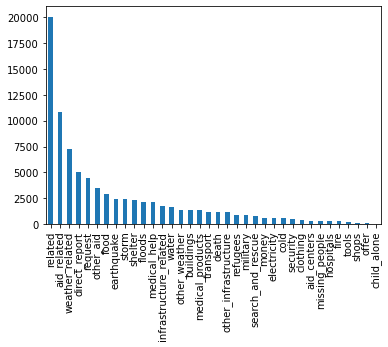

In [3]:
#lets see if the data is imbalanced
df.drop(columns=['message', 'original', 'genre', 'id']).sum().sort_values(ascending=False).plot.bar()

In [4]:
#plotting a list with the absolute value count
df.drop(columns=['message', 'original', 'genre', 'id']).sum().sort_values(ascending=False)

related                   20064
aid_related               10841
weather_related            7286
direct_report              5064
request                    4464
other_aid                  3441
food                       2917
earthquake                 2452
storm                      2440
shelter                    2308
floods                     2149
medical_help               2081
infrastructure_related     1705
water                      1669
other_weather              1376
buildings                  1331
medical_products           1311
transport                  1199
death                      1192
other_infrastructure       1151
refugees                    874
military                    859
search_and_rescue           724
money                       603
electricity                 532
cold                        528
security                    471
clothing                    404
aid_centers                 309
missing_people              298
hospitals                   283
fire    

In [5]:
#since the child_alone column are all 0, we can remove it as it doesn't 
#bring any information to the model and it prevents us from using the stratify
#option in the train_test_split
df.drop(columns=['child_alone'], inplace=True)

In [6]:
#the data is highly imbalanced, we will use the stratify parameter in the
#train_test_split to to ensure that relative class frequencies is approximately preserved

In [7]:
#checking for nulls
df.isnull().sum()

id                            0
message                       0
original                  16027
genre                         0
related                       0
request                       0
offer                         0
aid_related                   0
medical_help                  0
medical_products              0
search_and_rescue             0
security                      0
military                      0
water                         0
food                          0
shelter                       0
clothing                      0
money                         0
missing_people                0
refugees                      0
death                         0
other_aid                     0
infrastructure_related        0
transport                     0
buildings                     0
electricity                   0
tools                         0
hospitals                     0
shops                         0
aid_centers                   0
other_infrastructure          0
weather_

In [8]:
#the original column have a very high number of null rows
#since the important column to us the the message column, we simply won't use it

### 2. Write a tokenization function to process your text data

In [9]:
def tokenize(text):    
    #clean
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    
    #tokenize
    tokens = word_tokenize(text)
    
    #stop words
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    
    #initiate lammatizer
    lemmatizer = WordNetLemmatizer()
    
    #loop through each token and record
    clean_tokens = []
    for token in tokens:
        lemmatize = lemmatizer.lemmatize(token.lower().strip())
        clean_tokens.append(lemmatize)
        
    return clean_tokens

In [10]:
tokenize(df['message'][3])

['un',
 'report',
 'leogane',
 '80',
 '90',
 'destroyed',
 'only',
 'hospital',
 'st',
 'croix',
 'functioning',
 'need',
 'supply',
 'desperately']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [11]:
#lets start trying with randomforest and multioutputclassifier for simplicity

pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfid', TfidfTransformer()),
    ('classifier', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [12]:
X = df['message']
y = df.drop(columns=['id', 'message', 'original', 'genre'])

#since we are dealing with a multilabel classification problem and we 
#want to split the data in a stratified manner, we will need to use the 
#IterativeStratification method from scikit-multilearn because
#the train_test_split with stratify doesn't support it
#I tried to use the iterative_train_test_split method but 
#apperently there is some problem with it's subsetting
#https://github.com/scikit-multilearn/scikit-multilearn/issues/199

stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[0.25, 0.75])
train_indexes, test_indexes = next(stratifier.split(X, y))
X_train, y_train = X.loc[train_indexes], y.loc[train_indexes]
X_test, y_test = X.loc[test_indexes], y.loc[test_indexes]

In [13]:
#lets confirm that the split was successful
print('X size: {}'.format(X.shape[0]))
print('X_train size: {}'.format(X_train.shape[0]))
print('X_test size: {}'.format(X_test.shape[0]))
print('y_train size: {}'.format(y_train.shape[0]))
print('y_test size: {}'.format(y_test.shape[0]))

df_proportion = pd.DataFrame({'y': y.sum() / y.shape[0],
                             'y_train': y_train.sum() / y_train.shape[0],
                             'y_test': y_test.sum() / y_test.shape[0]})
df_proportion['y-y_train'] = abs(df_proportion['y'] - df_proportion['y_train'])
df_proportion['y-y_test'] = abs(df_proportion['y'] - df_proportion['y_test'])
print('y-y_train proportions difference: {}'.format(df_proportion['y-y_train'].sum()))
print('y-y_test proportions difference: {}'.format(df_proportion['y-y_test'].sum()))
df_proportion

X size: 26180
X_train size: 19635
X_test size: 6545
y_train size: 19635
y_test size: 6545
y-y_train proportions difference: 0.17373312961548257
y-y_test proportions difference: 0.5211993888464477


y   y_train    y_test  y-y_train  y-y_test
related                 0.766387  0.766387  0.766387   0.000000  0.000000
request                 0.170512  0.134556  0.278380   0.035956  0.107869
offer                   0.004507  0.004431  0.004736   0.000076  0.000229
aid_related             0.414095  0.414107  0.414057   0.000013  0.000038
medical_help            0.079488  0.087701  0.054851   0.008212  0.024637
medical_products        0.050076  0.053680  0.039267   0.003603  0.010810
search_and_rescue       0.027655  0.028317  0.025668   0.000662  0.001986
security                0.017991  0.019048  0.014820   0.001057  0.003170
military                0.032811  0.041457  0.006875   0.008645  0.025936
water                   0.063751  0.060810  0.072574   0.002941  0.008824
food                    0.111421  0.097886  0.152024   0.013535  0.040604
shelter                 0.088159  0.083728  0.101451   0.004431  0.013293
clothing                0.015432  0.013191  0.022154   0.002241  0.006723
money                   0.023033  0.023988  0.020168   0.000955  0.002865
missing_people          0.011383  0.011408  0.011306   0.000025  0.000076
refugees                0.033384  0.038044  0.019404   0.004660  0.013980
death                   0.045531  0.050216  0.031474   0.004686  0.014057
other_aid               0.131436  0.124166  0.153247   0.007270  0.021811
infrastructure_related  0.065126  0.067380  0.058365   0.002254  0.006761
transport               0.045798  0.047415  0.040947   0.001617  0.004851
buildings               0.050840  0.050828  0.050879   0.000013  0.000038
electricity             0.020321  0.020321  0.020321   0.000000  0.000000
tools                   0.006073  0.006672  0.004278   0.000598  0.001795
hospitals               0.010810  0.011103  0.009931   0.000293  0.000879
shops                   0.004584  0.004227  0.005653   0.000357  0.001070
aid_centers             0.011803  0.012834  0.008709   0.001031  0.003094
other_infrastructure    0.043965  0.046040  0.037739   0.002075  0.006226
weather_related         0.278304  0.278279  0.278380   0.000025  0.000076
floods                  0.082086  0.093150  0.048892   0.011064  0.033193
storm                   0.093201  0.092131  0.096409   0.001070  0.003209
fire                    0.010772  0.011561  0.008403   0.000789  0.002368
earthquake              0.093659  0.081793  0.129259   0.011867  0.035600
cold                    0.020168  0.021594  0.015890   0.001426  0.004278
other_weather           0.052559  0.057703  0.037128   0.005144  0.015432
direct_report           0.193430  0.158289  0.298854   0.035141  0.105424

In [14]:
#lets compare this with the traditional train_test_split from sklearn
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, random_state=42)

In [15]:
#lets confirm that the split was successful
print('X size: {}'.format(X.shape[0]))
print('X2_train size: {}'.format(X2_train.shape[0]))
print('X2_test size: {}'.format(X2_test.shape[0]))
print('y2_train size: {}'.format(y2_train.shape[0]))
print('y2_test size: {}'.format(y2_test.shape[0]))

df_proportion2 = pd.DataFrame({'y': y.sum() / y.shape[0],
                             'y2_train': y2_train.sum() / y2_train.shape[0],
                             'y2_test': y2_test.sum() / y2_test.shape[0]})
df_proportion2['y-y2_train'] = abs(df_proportion2['y'] - df_proportion2['y2_train'])
df_proportion2['y-y2_test'] = abs(df_proportion2['y'] - df_proportion2['y2_test'])
print('y-y2_train proportions difference: {}'.format(df_proportion2['y-y2_train'].sum()))
print('y-y2_test proportions difference: {}'.format(df_proportion2['y-y2_test'].sum()))
df_proportion2

X size: 26180
X2_train size: 19635
X2_test size: 6545
y2_train size: 19635
y2_test size: 6545
y-y2_train proportions difference: 0.027845683728036617
y-y2_test proportions difference: 0.08353705118411012


y  y2_train   y2_test  y-y2_train  y-y2_test
related                 0.766387  0.768373  0.760428    0.001986   0.005959
request                 0.170512  0.169595  0.173262    0.000917   0.002750
offer                   0.004507  0.004380  0.004889    0.000127   0.000382
aid_related             0.414095  0.413598  0.415584    0.000497   0.001490
medical_help            0.079488  0.079450  0.079603    0.000038   0.000115
medical_products        0.050076  0.050929  0.047517    0.000853   0.002559
search_and_rescue       0.027655  0.027451  0.028266    0.000204   0.000611
security                0.017991  0.017214  0.020321    0.000777   0.002330
military                0.032811  0.031831  0.035752    0.000980   0.002941
water                   0.063751  0.063509  0.064477    0.000242   0.000726
food                    0.111421  0.112045  0.109549    0.000624   0.001872
shelter                 0.088159  0.088261  0.087853    0.000102   0.000306
clothing                0.015432  0.015941  0.013904    0.000509   0.001528
money                   0.023033  0.023173  0.022613    0.000140   0.000420
missing_people          0.011383  0.011714  0.010390    0.000331   0.000993
refugees                0.033384  0.031831  0.038044    0.001553   0.004660
death                   0.045531  0.045531  0.045531    0.000000   0.000000
other_aid               0.131436  0.132162  0.129259    0.000726   0.002177
infrastructure_related  0.065126  0.063000  0.071505    0.002126   0.006379
transport               0.045798  0.045582  0.046448    0.000216   0.000649
buildings               0.050840  0.049860  0.053782    0.000980   0.002941
electricity             0.020321  0.020983  0.018335    0.000662   0.001986
tools                   0.006073  0.006213  0.005653    0.000140   0.000420
hospitals               0.010810  0.010441  0.011917    0.000369   0.001108
shops                   0.004584  0.003616  0.007487    0.000968   0.002903
aid_centers             0.011803  0.011154  0.013751    0.000649   0.001948
other_infrastructure    0.043965  0.043137  0.046448    0.000828   0.002483
weather_related         0.278304  0.282098  0.266921    0.003794   0.011383
floods                  0.082086  0.083932  0.076547    0.001846   0.005539
storm                   0.093201  0.093557  0.092131    0.000357   0.001070
fire                    0.010772  0.010848  0.010542    0.000076   0.000229
earthquake              0.093659  0.095034  0.089534    0.001375   0.004125
cold                    0.020168  0.020168  0.020168    0.000000   0.000000
other_weather           0.052559  0.054240  0.047517    0.001681   0.005042
direct_report           0.193430  0.192259  0.196944    0.001171   0.003514

In [16]:
#The standard train_test_split actually give us better results
#so we will continue with it
X = df['message']
y = df.drop(columns=['id', 'message', 'original', 'genre'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
start = time.time()
#training the random forest pipeline
with parallel_backend('threading', n_jobs=8): #used to paralelize the fit
    pipeline.fit(X_train, y_train)
elapsed = time.time() - start
print(elapsed)

182.6028594970703


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [18]:
y_pred = pipeline.predict(X_test)

In [19]:
y_test

related  request  offer  aid_related  medical_help  medical_products  \
1968         0        0      0            0             0                 0   
17679        1        0      0            0             0                 0   
5923         0        0      0            0             0                 0   
1087         1        1      0            1             1                 0   
7172         1        0      0            0             0                 0   
...        ...      ...    ...          ...           ...               ...   
6423         1        1      0            1             0                 0   
6919         1        0      0            0             0                 0   
7317         0        0      0            0             0                 0   
25651        1        0      0            0             0                 0   
19014        0        0      0            0             0                 0   

       search_and_rescue  security  military  water  ...  aid_centers  \
1968                   0         0         0      0  ...            0   
17679                  0         0         0      0  ...            0   
5923                   0         0         0      0  ...            0   
1087                   0         0         0      0  ...            0   
7172                   0         0         0      0  ...            0   
...                  ...       ...       ...    ...  ...          ...   
6423                   0         0         0      0  ...            0   
6919                   0         0         0      0  ...            0   
7317                   0         0         0      0  ...            0   
25651                  0         0         0      0  ...            0   
19014                  0         0         0      0  ...            0   

       other_infrastructure  weather_related  floods  storm  fire  earthquake  \
1968                      0                0       0      0     0           0   
17679                     0                0       0      0     0           0   
5923                      0                0       0      0     0           0   
1087                      0                0       0      0     0           0   
7172                      0                0       0      0     0           0   
...                     ...              ...     ...    ...   ...         ...   
6423                      0                1       0      1     0           1   
6919                      0                0       0      0     0           0   
7317                      0                0       0      0     0           0   
25651                     0                0       0      0     0           0   
19014                     0                0       0      0     0           0   

       cold  other_weather  direct_report  
1968      0              0              0  
17679     0              0              0  
5923      0              0              0  
1087      0              0              1  
7172      0              0              0  
...     ...            ...            ...  
6423      0              0              0  
6919      0              0              0  
7317      0              0              0  
25651     0              0              0  
19014     0              0              0  

[6545 rows x 35 columns]

In [20]:
#testing the code for one model
df_test2 = pd.DataFrame()
report_test = classification_report(y_test.iloc[:,0], y_pred[:,0], output_dict=True)
df_test = pd.DataFrame(report_test).iloc[:3,3]
df_test = pd.concat([df_test2, df_test])
df_test.rename(columns={df_test.columns[0] : y_test.columns[0]})

related
precision  0.779299
recall     0.674633
f1-score   0.700969

In [40]:
#since we have highly imbalanced data, we will go with the macro avg metric
#so each class have an equal weight
df_report = pd.DataFrame()
for i, v in enumerate(y_test):
    report = classification_report(y_test.iloc[:,i], y_pred[:,i], output_dict=True, zero_division=0)
    report = pd.DataFrame(report).iloc[:3,3]
    df_report = pd.concat([df_report, report], axis=1)
    df_report.rename(columns={df_report.columns[i] : y_test.columns[i]}, inplace=True)
df_report = df_report.transpose()
df_report

precision    recall  f1-score
related                  0.779299  0.674633  0.700969
request                  0.870783  0.731223  0.775669
offer                    0.497555  0.500000  0.498775
aid_related              0.777552  0.765294  0.769325
medical_help             0.818630  0.545365  0.563371
medical_products         0.891770  0.538184  0.559137
search_and_rescue        0.804561  0.518604  0.528657
security                 0.489838  0.499922  0.494829
military                 0.798781  0.525086  0.538511
water                    0.925102  0.676255  0.742637
food                     0.893806  0.771722  0.818174
shelter                  0.890443  0.685178  0.743873
clothing                 0.762801  0.537997  0.563842
money                    0.905732  0.516814  0.526902
missing_people           0.494805  0.500000  0.497389
refugees                 0.881269  0.507953  0.506166
death                    0.890261  0.589644  0.638293
other_aid                0.809497  0.517947  0.502187
infrastructure_related   0.630974  0.500904  0.483540
transport                0.886917  0.550426  0.579661
buildings                0.889667  0.560353  0.593902
electricity              0.991283  0.525000  0.543222
tools                    0.497173  0.500000  0.498583
hospitals                0.494041  0.500000  0.497003
shops                    0.496257  0.500000  0.498121
aid_centers              0.493125  0.500000  0.496538
other_infrastructure     0.476776  0.500000  0.488112
weather_related          0.878088  0.829264  0.849201
floods                   0.931724  0.715745  0.781848
storm                    0.886214  0.759366  0.807299
fire                     0.494728  0.499923  0.497312
earthquake               0.926135  0.894381  0.909488
cold                     0.990291  0.518939  0.531594
other_weather            0.819274  0.520419  0.527482
direct_report            0.838472  0.669608  0.707886

### 6. Improve your model
Use grid search to find better parameters. 

In [22]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x000002BCEF5F9820>)),
  ('tfid', TfidfTransformer()),
  ('classifier', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000002BCEF5F9820>),
 'tfid': TfidfTransformer(),
 'classifier': MultiOutputClassifier(estimator=RandomForestClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfid__norm': 'l2',
 'tfid__smooth_idf': True,
 'tfid__sublinear_tf'

In [23]:
#grid search with parallel processing, it took about 1 hour with 8 cores on a 9th gen i7 2.2Ghz with 8gb of ram
#start = time.time()
#with parallel_backend('threading', n_jobs=8):
#    parameters = {'classifier__estimator__min_samples_leaf': [1, 2],
#                  'classifier__estimator__min_samples_split': [2, 4],
#                  'classifier__estimator__n_estimators': [100, 200]}

#    cv = GridSearchCV(pipeline, parameters, scoring='f1_macro', cv=2)
#    cv.fit(X_train, y_train)

#elapsed = time.time() - start
#print(elapsed)

cv.cv_results_

{'mean_fit_time': array([ 746.83069479, 1296.14790618,  678.97463953, 1226.40756392,
         790.01018763,  887.13764822,  780.52179015,  976.72939503]),
 'std_fit_time': array([10.95283759,  9.67840469,  6.12980974, 14.17193437,  0.24451351,
         1.22423851,  2.32932508, 13.29320347]),
 'mean_score_time': array([901.86225879, 761.25261343, 862.6099515 , 727.66980684,
        791.49343503, 788.54778183, 640.35134363, 423.2940594 ]),
 'std_score_time': array([ 6.59378493,  2.49610007,  2.24478626, 10.42262018,  5.3449918 ,
         0.21644056,  0.44501972, 20.46273172]),
 'param_classifier__estimator__min_samples_leaf': masked_array(data=[1, 1, 1, 1, 2, 2, 2, 2],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__estimator__min_samples_split': masked_array(data=[2, 2, 4, 4, 2, 2, 4, 4],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__estimator__n_estimators': masked_array(data=[100, 200, 100, 200, 100, 200, 100, 200],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier__estimator__min_samples_leaf': 1,
   'classifier__estimator__min_samples_split': 2,
   'classifier__estimator__n_estimators': 100},
  {'classifier__estimator__min_samples_leaf': 1,
   'classifier__estimator__min_samples_split': 2,
   'classifier__estimator__n_estimators': 200},
  {'classifier__estimator__min_samples_leaf': 1,
   'classifier__estimator__min_samples_split': 4,
   'classifier__estimator__n_estimators': 100},
  {'classifier__estimator__min_samples_leaf': 1,
   'classifier__estimator__min_samples_split': 4,
   'classifier__estimator__n_estimators': 200},
  {'classifier__estimator__min_samples_leaf': 2,
   'classifier__estimator__min_samples_split': 2,
   'classifier__estimator__n_estimators': 100},
  {'classifier__estimator__min_samples_leaf': 2,
   'classifier__estimator__min_samples_split': 2,
   'classifier__estimator__n_estimators': 200},
  {'classifier__estimator__min_samples_leaf': 2,
   'classifier__estimator__min_samples_split': 4,
   'classifier__estimator__n_estimators': 100},
  {'classifier__estimator__min_samples_leaf': 2,
   'classifier__estimator__min_samples_split': 4,
   'classifier__estimator__n_estimators': 200}],
 'split0_test_score': array([0.23702134, 0.24210713, 0.25160478, 0.24513717, 0.18048841,
        0.18010073, 0.1806209 , 0.17759464]),
 'split1_test_score': array([0.23550601, 0.2412008 , 0.24442992, 0.24573819, 0.1816217 ,
        0.1742592 , 0.17694008, 0.17921489]),
 'mean_test_score': array([0.23626368, 0.24165396, 0.24801735, 0.24543768, 0.18105506,
        0.17717996, 0.17878049, 0.17840477]),
 'std_test_score': array([0.00075766, 0.00045317, 0.00358743, 0.00030051, 0.00056665,
        0.00292076, 0.00184041, 0.00081012]),
 'rank_test_score': array([4, 3, 1, 2, 5, 8, 6, 7])}

In [24]:
#saving results into a csv so we don't need to run it again for the same parameters
cv_rf_results = pd.DataFrame(cv.cv_results_)
cv_rf_results.to_csv('Random_Forest_CV.csv')

NameError: name 'cv' is not defined

In [ ]:
cv_rf_results

In [ ]:
#Since the result were worse than the standard, we won't use them
#The best gridsearch result was test_score = 0.2516047759365685

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [41]:
df_report

precision    recall  f1-score
related                  0.779299  0.674633  0.700969
request                  0.870783  0.731223  0.775669
offer                    0.497555  0.500000  0.498775
aid_related              0.777552  0.765294  0.769325
medical_help             0.818630  0.545365  0.563371
medical_products         0.891770  0.538184  0.559137
search_and_rescue        0.804561  0.518604  0.528657
security                 0.489838  0.499922  0.494829
military                 0.798781  0.525086  0.538511
water                    0.925102  0.676255  0.742637
food                     0.893806  0.771722  0.818174
shelter                  0.890443  0.685178  0.743873
clothing                 0.762801  0.537997  0.563842
money                    0.905732  0.516814  0.526902
missing_people           0.494805  0.500000  0.497389
refugees                 0.881269  0.507953  0.506166
death                    0.890261  0.589644  0.638293
other_aid                0.809497  0.517947  0.502187
infrastructure_related   0.630974  0.500904  0.483540
transport                0.886917  0.550426  0.579661
buildings                0.889667  0.560353  0.593902
electricity              0.991283  0.525000  0.543222
tools                    0.497173  0.500000  0.498583
hospitals                0.494041  0.500000  0.497003
shops                    0.496257  0.500000  0.498121
aid_centers              0.493125  0.500000  0.496538
other_infrastructure     0.476776  0.500000  0.488112
weather_related          0.878088  0.829264  0.849201
floods                   0.931724  0.715745  0.781848
storm                    0.886214  0.759366  0.807299
fire                     0.494728  0.499923  0.497312
earthquake               0.926135  0.894381  0.909488
cold                     0.990291  0.518939  0.531594
other_weather            0.819274  0.520419  0.527482
direct_report            0.838472  0.669608  0.707886

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [42]:
#lets try xgboost for comparison
#building the pipeline
pipeline_xgb = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfid', TfidfTransformer()),
    ('classifier', MultiOutputClassifier(XGBClassifier()))
])

In [ ]:
#training the xgboost pipeline

start = time.time()
with parallel_backend('threading', n_jobs=8): #used to paralelize the fit
    pipeline_xgb.fit(X_train, y_train)
elapsed = time.time() - start
print(elapsed)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.